In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

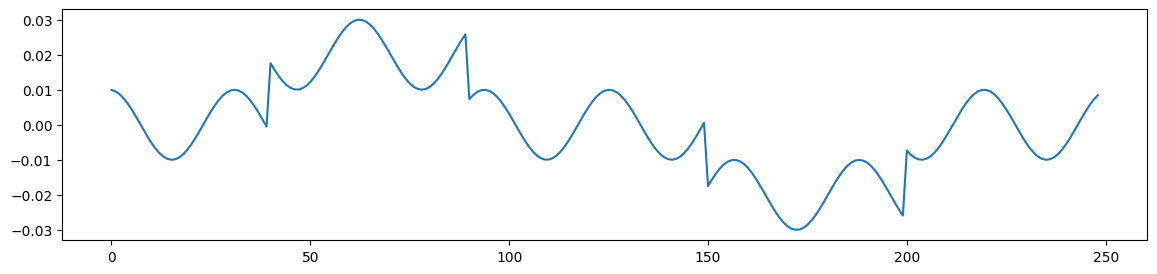

In [25]:
# vec = df['count'].values[0:600]

vec = np.sin(np.arange(250)/5)/20 #+ np.cos(np.arange(2000)/100)/10
# vec[0:50] += np.random.randn(50)/20
# vec[500:1000] += np.random.randn(500)/10
vec[40:90] += np.arange(0,50)/50
vec[90:150] += 50/50
vec[150:200] += 50/50-np.arange(0,50)/50



# first segment
# vec = vec[41:]
# thats it

# diff segments - MUCH BETTER, MAKE SIGNAL STATIONARY!!!!
vec = np.diff(vec)
# vec = vec[:148]
# vec = vec[:91]


plt.figure(figsize=(14,3))
plt.plot(vec)
# plt.plot(np.diff(vec))
plt.show()

In [26]:
vec[0:20]

array([ 0.00993347,  0.00953745,  0.00876121,  0.00763568,  0.00620574,
        0.00452841,  0.00267053,  0.00070619, -0.0012863 , -0.00322751,
       -0.00504005, -0.00665166, -0.00799809, -0.00902566, -0.00969341,
       -0.00997471, -0.00985835, -0.00934897, -0.00846687, -0.00724723])

In [27]:
vvv = np.insert(vec, obj=0, values=vec[20//2:0:-1])
www = np.insert(vvv, obj=-1, values=vec[-20//2:])
www.shape

(269,)

In [28]:
www.shape

(269,)

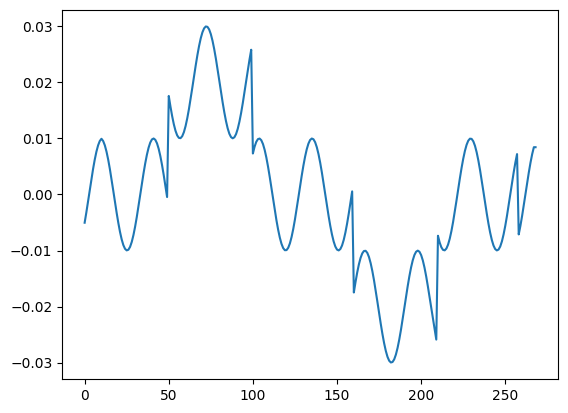

In [29]:
plt.plot(www)
plt.show()

In [89]:
w = 5
overlap = 1

X_list = []
j = 0
while j < www.shape[0]-w:
    X_list.append(www[j:j+w])
    j += 1
X = np.array(X_list)
X.shape

(264, 5)

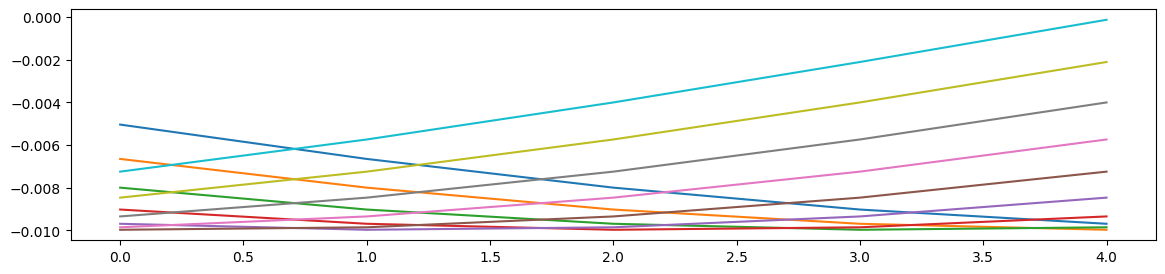

In [90]:
# a, b = 1000, 5
# X = vec[0:a*b].reshape(a, b)
plt.figure(figsize=(14,3))
for i in range(20,30):
    plt.plot(X[i])
plt.show()

In [91]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tqdm import tqdm

# KNN with distance matrix (filtered)

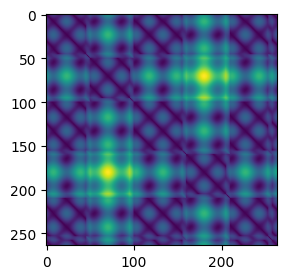

In [92]:
# faster KNN with pre-processed distances
from scipy.spatial import distance_matrix

X_dist = distance_matrix(X, X)
X_dist.shape

plt.figure(figsize=(3,3))
plt.imshow(X_dist)
plt.show()

In [93]:
from scipy.linalg import toeplitz
from scipy.spatial import distance_matrix
from sklearn.model_selection import StratifiedKFold

def create_X_and_distance_filtered(vec_ts, window_size=10):
    # train data creation
    window = window_size
    X_list = []
    j = 0
    while j < vec_ts.shape[0]-window:
        X_list.append(vec_ts[j:j+window])
        j += 1
    X = np.array(X_list)
    print('X shape=', X.shape)
    
    # distance matrix
    X_dist = distance_matrix(X, X)
    print('X_dist shape=', X_dist.shape)

    # filter on the diagonal so close points wont be so close
    col = np.zeros(X.shape[0])
    row = np.zeros(X.shape[0])
    col[0:window//2] = np.max(X_dist)*2
    row[0:window//2] = np.max(X_dist)*2
    filtr = toeplitz(col, row)

    X_dist += filtr
    
    return X, X_dist

X shape= (239, 10)
X_dist shape= (239, 239)


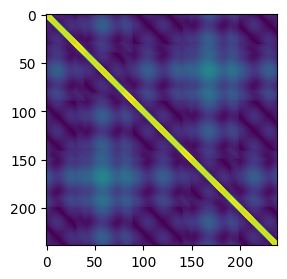

In [94]:
X, X_dist = create_X_and_distance_filtered(vec_ts=vec, window_size=10)
plt.figure(figsize=(3,3))
plt.imshow(X_dist)
plt.show()

In [95]:
def clasp_cross_val(X_dist, y, n_neighbors=3, n_splits=3, shuffle=False):
    scores = []
    kf = StratifiedKFold(n_splits=3, shuffle=shuffle)
    for i, (train_index, test_index) in enumerate(kf.split(np.arange(X_dist.shape[0]), y)):
        # knn model init
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='precomputed')

        # selecting train dist matrix
        X_train_single = X_dist[train_index]
        X_train_double = X_train_single.T[train_index]
        y_train = y[train_index]

        # selecting test dist matrix
        X_test_single = X_dist[test_index]
        X_test_double = X_test_single.T[train_index].T
        y_test = y[test_index]

        # fitting model
        knn.fit(X_train_double, y_train)

        # testing model
        y_pred = knn.predict(X_test_double)
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        
    return scores

In [96]:
# y index cycle
def clasp_single_run(X_dist):
    clasp = []
    for i in tqdm(range(3,X_dist.shape[0]-3)):
        y = np.ones(X_dist.shape[0])
        y[0:i] = 0
        scores = clasp_cross_val(X_dist, y, n_neighbors=3, n_splits=3, shuffle=True)

        clasp.append(np.mean(scores))
    return clasp

In [97]:
X, X_dist = create_X_and_distance_filtered(vec_ts=www, window_size=10)
# X_dist = X_dist[:489].T[:489]
clasp = clasp_single_run(X_dist)

X shape= (259, 10)
X_dist shape= (259, 259)


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:09<00:00, 26.57it/s]


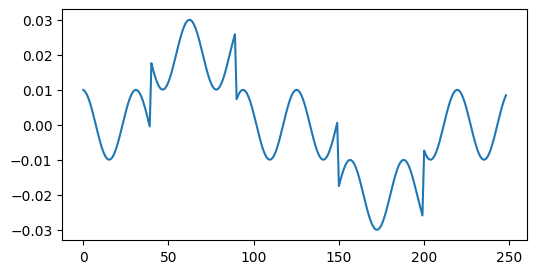

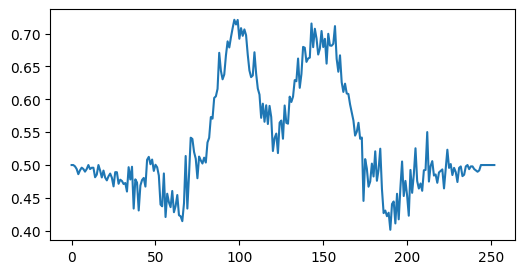

In [98]:
plt.figure(figsize=(6,3))
plt.plot(vec)
plt.show()

plt.figure(figsize=(6,3))
plt.plot(clasp)
plt.show()

### CLaSP with SVD rank=1 approximation

In [99]:
# PCA cross-val
from sklearn.decomposition import PCA
def clasp_svd(X_dist, split_idx):
    X_dist_left = X_dist[0:split_idx].T[0:split_idx]
    X_dist_right = X_dist[split_idx:].T[split_idx:]   
    
    pca_left = PCA(n_components=1)
    pca_left.fit(X_dist_left)
    X_dist_left_pca = pca_left.inverse_transform(pca_left.transform(X_dist_left))
    
    pca_right = PCA(n_components=1)
    pca_right.fit(X_dist_right)
    X_dist_right_pca = pca_right.inverse_transform(pca_right.transform(X_dist_right))
    
    # no need to normalize since we summ the error of the both halves of matrix
    score_left = np.linalg.norm(X_dist_left_pca - X_dist_left)#/np.linalg.norm(X_dist_left)
    score_right = np.linalg.norm(X_dist_right_pca - X_dist_right)#/np.linalg.norm(X_dist_right)
    return score_left + score_right

In [100]:
X_dist = distance_matrix(X, X)
# X_dist = X_dist[85+130::].T[85+130::]

In [101]:
clasp_pca = []
for i in tqdm(range(3,X_dist.shape[0]-3)):
    score = clasp_svd(X_dist, split_idx=i)
    clasp_pca.append(score)

100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:04<00:00, 51.15it/s]


In [102]:
np.argmax(-np.array(clasp_pca[10:-10]))+10

120

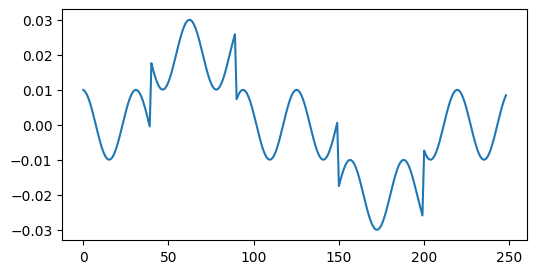

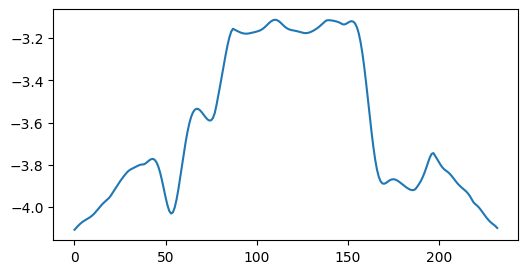

In [103]:
plt.figure(figsize=(6,3))
plt.plot(vec)#[85+130:])
plt.show()

plt.figure(figsize=(6,3))
plt.plot(-np.array(clasp_pca[10:-10]))
# plt.plot(-50+10*np.diff(-np.array(clasp_pca[10:-10])))
plt.show()

# Final class with KNN and SVD solvers

In [46]:
import numpy as np
from collections import deque
from tqdm import tqdm

from scipy.linalg import toeplitz
from scipy.spatial import distance_matrix

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

# FUNCTIONAL CLASS
class CLaSP():
    def __init__(self, window=10, cycles=3, solver='knn'):
        assert solver == 'knn' or solver == 'svd', 'Solver must be knn or svd'
        assert window % 2 == 0 , 'Window must be even'
        
        self.window = window
        self.cycles = cycles
        self.solver = solver
        self.stack = deque([])
    
    def fit(self, vec_ts, n_segments=3):
        # create X_dist and X
        self.create_X_and_distance_filtered(vec_ts)
        
        # initialize stack
        first_elem = {'start':0,
                      'stop':self.X_dist.shape[0],
                      'clasp_scores':None,
                      'clasp_max_idx':None,
                      'clasp_max_val':None}
        self.stack.append(first_elem)
        
        # while we don't have enough segments
        while len(self.stack) < n_segments:
            # calculate clasp on all elements
            for i in range(len(self.stack)):
                elem = self.stack.popleft()
                if elem['clasp_max_idx'] is not None:
                    self.stack.append(elem) # put it back
                if elem['clasp_max_idx'] is None:
                    # skip short segents
                    if elem['stop'] - elem['start'] < self.window*3+1:
                        elem['clasp_max_idx'] = -1
                        elem['clasp_max_val'] = 0
                        self.stack.append(elem)
                        continue
                    # selecting the slice and calculating clasp scores
                    X_dist_cur = self.X_dist[elem['start']:elem['stop']].T[elem['start']:elem['stop']]
                    print('X_dist_cur', X_dist_cur.shape)
                    clasp_scores_cur = self.clasp_single_run(X_dist_cur)
                    dividing_idx = np.argmax(clasp_scores_cur[self.window:-self.window]) + self.window
                    dividing_val = clasp_scores_cur[dividing_idx]
                    elem['clasp_max_idx'] = dividing_idx
                    elem['clasp_max_val'] = dividing_val
#                     elem['clasp_scores'] = clasp_scores_cur
                    self.stack.append(elem) # put it back
                
            # comparison of computed CLASP vectors before splitting
            max_val = 0
            max_elem = None
            max_idx = None
            for i in range(len(self.stack)):
                elem = self.stack[i]
                if elem['clasp_max_val'] > max_val:
                    max_val = elem['clasp_max_val']
                    max_elem, max_idx = elem, i
            print(max_idx)
            # remove element from deque stack
            del self.stack[max_idx]
                
            # creating and adding best element split to stack
            left_elem = {'start':max_elem['start'],
                         'stop':max_elem['start']+max_elem['clasp_max_idx'],
                         'clasp_scores':None,
                         'clasp_max_idx':None}
            right_elem = {'start':max_elem['start']+max_elem['clasp_max_idx'],
                         'stop':max_elem['stop'],
                         'clasp_scores':None,
                         'clasp_max_idx':None}
            self.stack.append(left_elem)
            self.stack.append(right_elem)
                
    # dataset creation
    def create_X_and_distance_filtered(self, vec_ts):
        # expand vec by window//2 to keep same dims
        vec_left_expand = np.insert(vec_ts, obj=0, values=vec[self.window//2:0:-1])
        vec_both_expand = np.insert(vec_left_expand, obj=-1, values=vec[-self.window//2:])
        # matrix creation
        X_list = []
        j = 0
        while j < vec_both_expand.shape[0]-self.window:
            X_list.append(vec_both_expand[j:j+self.window])
            j += 1
        X = np.array(X_list)
        print('X shape=', X.shape)
        # distance matrix
        X_dist = distance_matrix(X, X)
        print('X_dist shape=', X_dist.shape)

        # filter on the diagonal so close points wont be so close
        col = np.zeros(X.shape[0])
        row = np.zeros(X.shape[0])
        col[0:self.window//2] = np.max(X_dist)*2
        row[0:self.window//2] = np.max(X_dist)*2
        filtr = toeplitz(col, row)
        X_dist += filtr
        # writing to class attributes
        self.X, self.X_dist =  X, X_dist
    
    # cross validation on single split of y
    def clasp_cross_val(self, X_dist, y, n_neighbors=3, n_splits=3, shuffle=False):
        scores = []
        kf = StratifiedKFold(n_splits=3, shuffle=shuffle)
        for i, (train_index, test_index) in enumerate(kf.split(np.arange(X_dist.shape[0]), y)):
            # knn model init
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='precomputed')
            # selecting train dist matrix
            X_train_double = X_dist[train_index].T[train_index]
            y_train = y[train_index]
            # selecting test dist matrix
            X_test_double = X_dist[train_index].T[test_index]
            y_test = y[test_index]
            # fitting model
            knn.fit(X_train_double, y_train)
            # testing model
            y_pred = knn.predict(X_test_double)
            score = roc_auc_score(y_test, y_pred)
            scores.append(score)
        return scores
    
    # SVD cross-val
    def clasp_svd(self, X_dist, split_idx):
        X_dist_left = X_dist[0:split_idx].T[0:split_idx]
        X_dist_right = X_dist[split_idx:].T[split_idx:]   

        pca_left = PCA(n_components=1)
        pca_left.fit(X_dist_left)
        X_dist_left_pca = pca_left.inverse_transform(pca_left.transform(X_dist_left))

        pca_right = PCA(n_components=1)
        pca_right.fit(X_dist_right)
        X_dist_right_pca = pca_right.inverse_transform(pca_right.transform(X_dist_right))

        # no need to normalize since we summ the error of the both halves of matrix
        score_left = np.linalg.norm(X_dist_left_pca - X_dist_left)/np.linalg.norm(X_dist_left)
        score_right = np.linalg.norm(X_dist_right_pca - X_dist_right)/np.linalg.norm(X_dist_right)
        return score_left + score_right
    
    # cycling over all y-splits
    def clasp_single_run(self, X_dist):
        clasp = []
        for i in tqdm(range(3, X_dist.shape[0]-3)):
            y = np.ones(X_dist.shape[0])
            y[0:i] = 0
            if self.solver == 'knn':
                scores = self.clasp_cross_val(X_dist, y, n_neighbors=3, n_splits=3, shuffle=True)
            elif self.solver == 'svd':
                scores = self.clasp_svd(X_dist, i)
            
            clasp.append(np.mean(scores))
        return clasp

In [84]:
cls = CLaSP(window=6, solver='knn')

In [85]:
cls.fit(vec, n_segments=5)

X shape= (249, 6)
X_dist shape= (249, 249)
X_dist_cur (249, 249)


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [00:08<00:00, 28.50it/s]


0
X_dist_cur (91, 91)


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:01<00:00, 50.85it/s]


X_dist_cur (158, 158)


100%|████████████████████████████████████████████████████████████████████████████████| 152/152 [00:03<00:00, 38.03it/s]


0
X_dist_cur (39, 39)


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 63.93it/s]


X_dist_cur (52, 52)


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 60.11it/s]


0
X_dist_cur (51, 51)


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 54.20it/s]


X_dist_cur (107, 107)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:02<00:00, 42.29it/s]

3


In [86]:
len(cls.stack)

5

In [87]:
# cls.stack

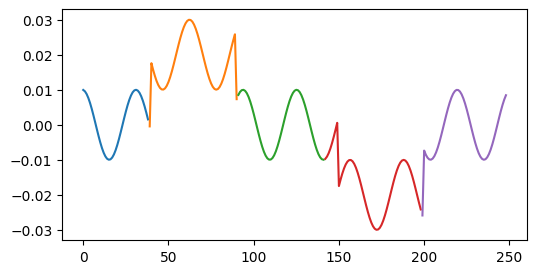

In [88]:
plt.figure(figsize=(6,3))
for i, elem in enumerate(cls.stack):
    plt.plot(np.arange(elem['start'],elem['stop']),  vec[elem['start']:elem['stop']])
plt.show()

In [355]:
knn = KNeighborsClassifier(n_neighbors=3)
%timeit knn.fit(X[train_index], y[train_index])

1.06 ms ± 52.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [356]:
knn = KNeighborsClassifier(n_neighbors=3, metric='precomputed')
%timeit knn.fit(X_train_double, y[train_index])

1e+03 µs ± 89.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### KNN with STFT

In [357]:
from scipy.signal import stft

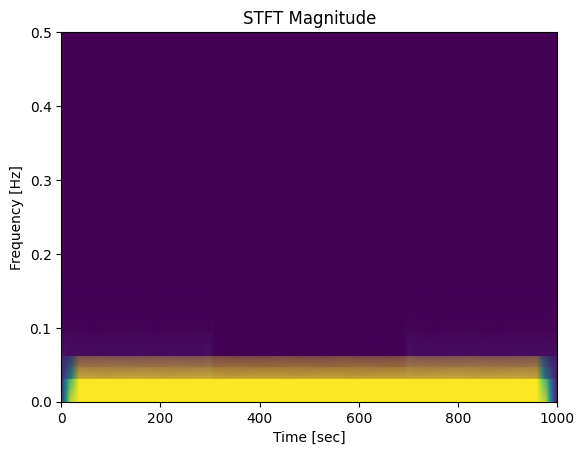

In [358]:
f, t, Zxx = stft(vec, fs=1, nperseg=32, noverlap=31)

plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

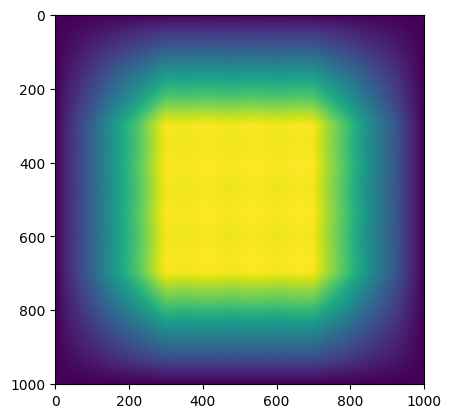

In [359]:
covariance = np.abs(np.cov(Zxx.T))
plt.imshow(covariance)
plt.show()

In [399]:
clasp = []
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
logreg = LogisticRegression(random_state=0)

# scaler = StandardScaler()
# pca = PCA(n_components=3)
# X = pca.fit_transform(X)
# X = scaler.fit_transform(X)

for i in tqdm(range(3,X.shape[0]-3)):
    y = np.ones(X.shape[0])
#     y = np.ones(Zxx.shape[1])
    
    y[0:i] = 0
    
#     scores = cross_val_score(knn, np.abs(Zxx.T), y, cv=3, scoring=make_scorer(roc_auc_score))
    scores = cross_val_score(knn, X, y, cv=3, scoring=make_scorer(roc_auc_score))
    
    clasp.append(np.mean(scores))

100%|████████████████████████████████████████████████████████████████████████████████| 983/983 [00:11<00:00, 85.56it/s]


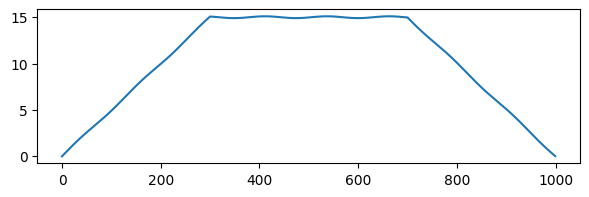

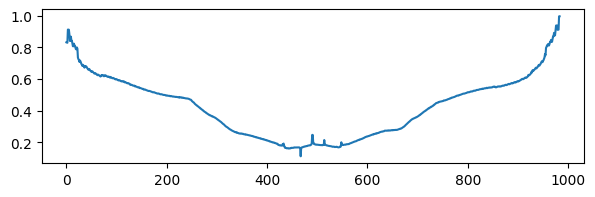

In [361]:
plt.figure(figsize=(7,2))
plt.plot(vec)
# plt.plot(np.arange(0,500), vec[0:500])
# plt.plot(np.arange(500,1000), vec[500:1000])
# plt.plot(np.arange(1000,2000), vec[1000:2000])

# plt.plot(np.arange(1000,1300), vec[1000:1300])
# plt.plot(np.arange(1300,1600), vec[1300:1600])
# plt.plot(np.arange(1600,2000), vec[1600:2000])
plt.show()

plt.figure(figsize=(7,2))
plt.plot(np.array(clasp))
plt.show()

In [12]:
from claspy.segmentation import BinaryClaSPSegmentation

In [22]:
vec.shape

(2000,)

In [30]:
clasp = BinaryClaSPSegmentation(n_segments=4)
clasp.fit(vec[0:50])

C:\Users\79219\AppData\Roaming\Python\Python38\site-packages\claspy\segmentation.py:206: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(


In [33]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset

In [34]:
dataset, window_size, true_cps, time_series = load_tssb_dataset(names=("CricketX",)).iloc[0,:]
clasp = BinaryClaSPSegmentation()
clasp.fit_predict(time_series)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mUse of unsupported NumPy function 'numpy.clip' or unsupported use of the function.
[1m
File "AppData\Roaming\Python\Python38\site-packages\claspy\distance.py", line 51:[0m
[1mdef sliding_mean_std(time_series, window_size):
    <source elided>

[1m    movstd = np.sqrt(np.clip(segSumSq / window_size - (segSum / window_size) ** 2, 0, None))
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\79219\AppData\Roaming\Python\Python38\site-packages\claspy\distance.py (51)[0m
[1m
File "AppData\Roaming\Python\Python38\site-packages\claspy\distance.py", line 51:[0m
[1mdef sliding_mean_std(time_series, window_size):
    <source elided>

[1m    movstd = np.sqrt(np.clip(segSumSq / window_size - (segSum / window_size) ** 2, 0, None))
[0m    [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function sliding_mean_std at 0x000001EC3993ED30>))[0m
[0m[1mDuring: typing of call at C:\Users\79219\AppData\Roaming\Python\Python38\site-packages\claspy\nearest_neighbour.py (172)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function sliding_mean_std at 0x000001EC3993ED30>))[0m
[0m[1mDuring: typing of call at C:\Users\79219\AppData\Roaming\Python\Python38\site-packages\claspy\nearest_neighbour.py (172)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function sliding_mean_std at 0x000001EC3993ED30>))[0m
[0m[1mDuring: typing of call at C:\Users\79219\AppData\Roaming\Python\Python38\site-packages\claspy\nearest_neighbour.py (172)
[0m
[1m
File "AppData\Roaming\Python\Python38\site-packages\claspy\nearest_neighbour.py", line 172:[0m
[1mdef _knn(time_series, start, end, window_size, k_neighbours, tcs, dot_first, dot_ref, distance, distance_preprocessing):
    <source elided>
    dot_prev = None
[1m    preprocessing = distance_preprocessing(time_series, window_size)
[0m    [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _knn at 0x000001EC39946D30>))[0m
[0m[1mDuring: typing of call at C:\Users\79219\AppData\Roaming\Python\Python38\site-packages\claspy\nearest_neighbour.py (246)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _knn at 0x000001EC39946D30>))[0m
[0m[1mDuring: typing of call at C:\Users\79219\AppData\Roaming\Python\Python38\site-packages\claspy\nearest_neighbour.py (246)
[0m
[1m
File "AppData\Roaming\Python\Python38\site-packages\claspy\nearest_neighbour.py", line 246:[0m
[1mdef _parallel_knn(time_series, window_size, k_neighbours, pranges, tcs, distance, distance_preprocessing):
    <source elided>

[1m        dists[start:end, :], knns[start:end, :] = _knn(
[0m        [1m^[0m[0m
